In [0]:
!wget https://www.dropbox.com/s/2nvu2sv707l8jaf/ORLProcessed.zip
!unzip ORLProcessed.zip

--2020-05-11 10:36:30--  https://www.dropbox.com/s/2nvu2sv707l8jaf/ORLProcessed.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/2nvu2sv707l8jaf/ORLProcessed.zip [following]
--2020-05-11 10:36:31--  https://www.dropbox.com/s/raw/2nvu2sv707l8jaf/ORLProcessed.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc85d60731ba7ab3aae523c3a8cc.dl.dropboxusercontent.com/cd/0/inline/A3j5tahER7_eBlOUwGBJGsDXLV1EQTsfQty8owBccINbweDi-jYQgOndBKCR_7YdcwcHfr4981OS3iOlZDnkM-yBPkRQwLQy4bRn0Bw1OC7bGfZHTyr1QE0_zUo4neHLgGQ/file# [following]
--2020-05-11 10:36:31--  https://uc85d60731ba7ab3aae523c3a8cc.dl.dropboxusercontent.com/cd/0/inline/A3j5tahER7_eBlOUwGBJGsDXLV1EQTsfQty8owBccINbweDi-jYQgOndBKCR_7YdcwcHfr4981OS3iOlZDnkM-yBPkRQwLQy4bR

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import os
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Lambda, Input, GaussianNoise,concatenate
from keras.layers.normalization import BatchNormalization as BN
from keras.optimizers import SGD, Adam
from keras.models import Model,Sequential
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier




TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
dir_path_train= "ORLProcessed/Train"
dir_path_test= "ORLProcessed/Test"
tamaño = (112,92,1)
representacion = 200
alpha = 1
num_clases = 40 

In [0]:
def read_pgm(name):
    with open(name) as f:
        lines = f.readlines()

    # Ignores commented lines
    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)

    # Makes sure it is ASCII format (P2)
    assert lines[0].strip() == 'P2' 

    # Converts data to a list of integers
    data = []
    for line in lines[1:]:
        data.extend([int(c) for c in line.split()])

    return (np.array(data[3:]),(data[1],data[0]),data[2])

In [0]:
def get_dataset_array(dirpath):
    images = []
    labels = []
    for usuario_sistema in os.listdir(dirpath):
        try:
            folderPath = os.path.join(dirpath,usuario_sistema)
            for file in os.listdir(folderPath):
                filePath = os.path.join(folderPath,file)
                data = read_pgm(filePath)
                images.append(data[0])
                tamañoImagen = data[1]
                labels.append(usuario_sistema)
        except:
            print("Error de lectura %s" % usuario_sistema)
    print("Imagenes procesadas %d total de individuos %d tamañoImagen %s " %(len(images),len(set(labels)),tamañoImagen))
    return np.matrix(images),labels

In [0]:
imagesTrain,labelsTrain = get_dataset_array(dir_path_train)
imagesTest,labelsTest = get_dataset_array(dir_path_test)

Error de lectura .DS_Store
Imagenes procesadas 200 total de individuos 40 tamañoImagen (112, 92) 
Error de lectura .DS_Store
Imagenes procesadas 200 total de individuos 40 tamañoImagen (112, 92) 


In [0]:
def CBGN(model,filters,ishape=None):
  if ishape:
    model.add(Conv2D(filters, (3, 3), padding='same',
                  input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))

    model.add(BN())
    model.add(GaussianNoise(0.1))
    model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))

In [0]:
def generate_model():
  model = Sequential()
  CBGN(model,32,ishape=tamaño)
  CBGN(model,64)
  CBGN(model,128)
  CBGN(model,256)
  CBGN(model,512)
  model.add(Flatten())
  model.add(Dense(representacion))
  model.add(Activation("linear"))
  return model
  

In [0]:
model = generate_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 112, 92, 32)       320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 46, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 46, 64)        256       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 56, 46, 64)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 56, 46, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 23, 64)       

In [0]:
#https://github.com/davidsandberg/facenet/blob/master/src/facenet.py
def triplet_loss(anchor, positive, negative, alpha):
      pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), 1)
      neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), 1)
      
      basic_loss = tf.add(tf.subtract(pos_dist,neg_dist), alpha)
      loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), 0)
      return loss
      

In [0]:
#metrics
def pos_metric(y_true,y_pred):
  
  anchor = y_pred[0:representacion-1]
  positive = y_pred[representacion:2*representacion-1]
  negative = y_pred[2*representacion:-1]
  pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), 1)
  return pos_dist
def neg_metric(y_true,y_pred):
  anchor = y_pred[0:representacion]
  positive = y_pred[representacion:2*representacion]
  negative = y_pred[2*representacion:-1]
  negative_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), 1)
  return negative_dist


In [0]:
def generate_siamese(backbone,optimizer="adam"):
  anchor_input = Input(shape=(tamaño[0],tamaño[1],1),name="anchor")
  positive_input = Input(shape=(tamaño[0],tamaño[1],1),name="positive")
  negative_input = Input(shape=(tamaño[0],tamaño[1],1),name="negative")
  anchor_representation = backbone(anchor_input)
  positive_representation = backbone(positive_input)
  negative_representation = backbone(negative_input)
  
  loss = triplet_loss(anchor_representation, positive_representation, negative_representation, alpha)
  vec_representations  = concatenate([anchor_representation, positive_representation, negative_representation],axis=-1)
  model = Model(inputs=[anchor_input,positive_input,negative_input],
                outputs=vec_representations)
  model.add_loss(loss)
  
  model.compile(optimizer=optimizer,)
  return model

In [0]:
model_siames = generate_siamese(model)

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output concatenate_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to concatenate_1.
  'be expecting any data to be passed to {0}.'.format(name))


In [0]:
model_siames.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
positive (InputLayer)           (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
negative (InputLayer)           (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 200)          2186440     anchor[0][0]                     
                                                                 positive[0][0]             

In [0]:
imagesTrain.shape

(200, 10304)

In [0]:
def data_generator(x, y, batch_size=32):
  """
  Extrae muestras formadass por imagenes Anchor, Positive, negative, anchor_representation,positive_representation,negative_representation
  """
  y = np.array(y)
  while True:
    anchor_batch = np.empty((batch_size,tamaño[0],tamaño[1]),dtype=np.float32)
    positive_batch = np.empty((batch_size,tamaño[0],tamaño[1]),dtype=np.float32)
    negative_batch = np.empty((batch_size,tamaño[0],tamaño[1]),dtype=np.float32)
    for i in range(batch_size):
      target_label =np.random.choice(y)
      negative_label = np.random.choice(y)
      while negative_label == target_label:
        negative_label = np.random.choice(y)
    
      anchor_idx =  np.random.choice(np.where(y== target_label)[0])
      positive_idx =  np.random.choice(np.where(y== target_label)[0])
      while positive_idx == anchor_idx:
        positive_idx =  np.random.choice(np.where(y== target_label)[0])
      
      negative_idx = np.random.choice(np.where(y== negative_label)[0])
      #print(target_label,negative_label,anchor_idx,positive_idx,negative_idx)
      anchor = np.reshape(x[anchor_idx],(tamaño[0],tamaño[1]))
      positive = np.reshape(x[positive_idx],(tamaño[0],tamaño[1]))
      negative = np.reshape(x[negative_idx],(tamaño[0],tamaño[1]))
      anchor_batch[i] = anchor /256
      positive_batch[i] = positive /256
      negative_batch[i] = negative /256
    anchor_batch = np.reshape(anchor_batch,(batch_size,tamaño[0],tamaño[1],1))
    positive_batch = np.reshape(positive_batch,(batch_size,tamaño[0],tamaño[1],1))
    negative_batch = np.reshape(negative_batch,(batch_size,tamaño[0],tamaño[1],1))
    yield ([anchor_batch,positive_batch,negative_batch],[])

In [0]:
gen = data_generator(imagesTrain,labelsTrain,batch_size=2)
x,y = next(gen)

In [0]:
x[0].shape

(2, 112, 92, 1)

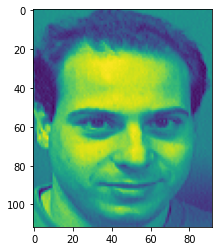

In [0]:
plt.imshow(np.reshape(x[0][0],(112,92)))


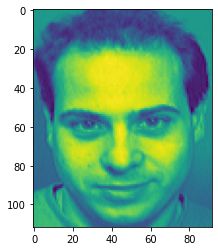

In [0]:
plt.imshow(np.reshape(x[1][0],(112,92)))


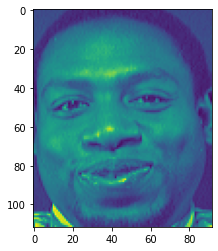

In [0]:
plt.imshow(np.reshape(x[2][0],(112,92)))

In [0]:
history = model_siames.fit_generator(data_generator(imagesTrain,labelsTrain,batch_size=256),steps_per_epoch=50,
                                     epochs=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
50/50 [==============================] - 46s 919ms/step - loss: 0.3114
Epoch 2/50
50/50 [==============================] - 37s 735ms/step - loss: 0.1723
Epoch 3/50
50/50 [==============================] - 37s 736ms/step - loss: 0.4076
Epoch 4/50
50/50 [==============================] - 37s 740ms/step - loss: 0.0750
Epoch 5/50
50/50 [==============================] - 37s 732ms/step - loss: 0.0937
Epoch 6/50
50/50 [==============================] - 37s 732ms/step - loss: 0.1306
Epoch 7/50
50/50 [==============================] - 37s 731ms/step - loss: 0.0102
Epoch 8/50
50/50 [==============================] - 37s 730ms/step - loss: 0.0201
Epoch 9/50
50/50 [==============================] - 37s 738ms/step - loss: 0.0250
Epoch 10/50
50/50 [==============================] - 36s 725ms/step - loss: 0.0101
Epoch 11/50
50/50 [==============================] - 37s 732ms/step - loss: 0.0088
E

In [0]:
anchor = x[0]
positive = x[1]
negative = x[2]

Comprobamos que la distancia del anchor al positive es inferior a la distancia del anchor al negative

In [0]:
from sklearn.metrics.pairwise import euclidean_distances

In [0]:
euclidean_distances(model.predict(anchor)[1].reshape(1,-1),model.predict(positive)[1].reshape(1,-1))

array([[10.666773]], dtype=float32)

In [0]:
euclidean_distances(model.predict(anchor)[1].reshape(1,-1),model.predict(negative)[1].reshape(1,-1))

array([[17.123655]], dtype=float32)

In [0]:
imagesTrain2 = np.empty((200,112,92))
imagesTest2 = np.empty((200,112,92))
for i in range(0,imagesTrain.shape[0]):
  imagesTrain2[i] =np.reshape(imagesTrain[i],(112,92,1))
for i in range(0,imagesTest.shape[0]):
  imagesTest2[i] =np.reshape(imagesTest[i],(112,92,1))
imagesTest2 = np.reshape(imagesTest2,(200,112,92,1))
imagesTrain2 = np.reshape(imagesTrain2,(200,112,92,1))

In [0]:
model.predict(imagesTrain2).shape

(200, 200)

In [0]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(model.predict(imagesTrain2),labelsTrain)
clf.score(model.predict(imagesTest2),labelsTest)

0.865